## Sampling from different FNN layers

Sampling from the output is not yet integrated here, use sampling-fnn-outputs.ipynb for that

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import os
from utils import createFlowDataset, subps  # Assuming these functions are in your utils module
from glob import glob
from time import time
import sys

from torchvision import models
import torch.nn as nn

print(torch.__version__)  # E.g., '1.10.0'

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

import fnn
from fnn import microns
from numpy import full, concatenate

model, ids = microns.scan(session=8, scan_idx=5)
print(ids)


################# SET PARAMS ##########################
block = ['blocks.2'] # choose from 'inputs.0', 'inputs.1', 'inputs.2', 'blocks.0', 'blocks.1', 'blocks.2', 'hidden', 'recurrent.out', 'position', 'readout'
n_fmaps_to_sample = 40
samples_per_fmap = 50
seed = 3

################## MORE PARAMS ########################
# I suggest leaving these unchanged for comparability

LAYER_TYPE = 'act'
MAX_SIDE = 32

# Flow stimuli parameters
scl_factor = 0.7
N_INSTANCES = 3
trial_len = 75 // 2  # Number of frames
stride = 1

model_name = 'fnn07'

## SAMPLING
fmap_samp_method = 'maxFr'
samp_max_one_dir = False # samples high activities to horizontal movement to the right only if set to True
neur_samp_method = 'maxNr'

input_shape = (144, 256)
save_hidden = False # hacky hidden state debugging

get_pos = True if "position" in block else False
if get_pos:
    block[block == "position"] = 'recurrent.out'

get_act = any(item in block for item in ['inputs.0', 'inputs.1', 'inputs.2', 'blocks.0', 'blocks.1', 'blocks.2'])

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total number of parameters: {total_params}')

2.6.0+cu124
Using device: cuda
            session  scan_idx  unit_id
readout_id                            
0                 8         5        1
1                 8         5        2
2                 8         5        3
3                 8         5        4
4                 8         5        5
...             ...       ...      ...
9936              8         5    10570
9937              8         5    10571
9938              8         5    10572
9939              8         5    10574
9940              8         5    10575

[9941 rows x 3 columns]
Total number of parameters: 9727431


In [2]:
for name, module in model.named_modules():
    print(f"Module name: {name}, type: {type(module).__name__}")

Module name: , type: Visual
Module name: core, type: FeedforwardRecurrent
Module name: core.feedforward, type: InputDense
Module name: core.feedforward.inputs, type: ModuleList
Module name: core.feedforward.inputs.0, type: Conv
Module name: core.feedforward.inputs.0.weights, type: ParameterList
Module name: core.feedforward.inputs.0.biases, type: ParameterList
Module name: core.feedforward.inputs.1, type: Conv
Module name: core.feedforward.inputs.1.weights, type: ParameterList
Module name: core.feedforward.inputs.1.gains, type: ParameterList
Module name: core.feedforward.inputs.1.biases, type: ParameterList
Module name: core.feedforward.inputs.2, type: Conv
Module name: core.feedforward.inputs.2.weights, type: ParameterList
Module name: core.feedforward.inputs.2.gains, type: ParameterList
Module name: core.feedforward.inputs.2.biases, type: ParameterList
Module name: core.feedforward.blocks, type: ModuleList
Module name: core.feedforward.blocks.0, type: Block
Module name: core.feedforw

In [3]:
print(model.readout.feature.weights[0].shape)

torch.Size([9941, 1, 128])


(9941, 512)
(9941, 5)


/home/jb3879/RecurrentEncodingManifolds/.venv/lib64/python3.11/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X


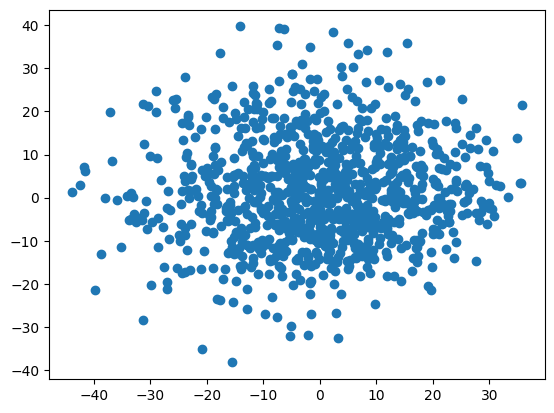

In [4]:
readout1 = model.readout.feature.weights[0][:, 0, :].cpu().detach().numpy()
readout2 = model.readout.feature.weights[0][:, 0, :].cpu().detach().numpy()
readout3 = model.readout.feature.weights[0][:, 0, :].cpu().detach().numpy()
readout4 = model.readout.feature.weights[0][:, 0, :].cpu().detach().numpy()

weights = np.concatenate([readout1, readout2, readout3, readout4], axis=1)
print(weights.shape)

from sklearn.decomposition import PCA

pca_decoding = PCA(n_components=5)
pca_decoding_result = pca_decoding.fit_transform(
    weights
)

print(pca_decoding_result.shape)

plt.scatter(pca_decoding_result[:1000, 0], pca_decoding_result[:1000, 1])
plt.show()

#reshaped_decoding_result = pca_decoding_result.reshape(11*8, -1)

#plt.plot(model.readout.feature.weights[0][:, 0, :].cpu().detach().numpy())
#plt.show()

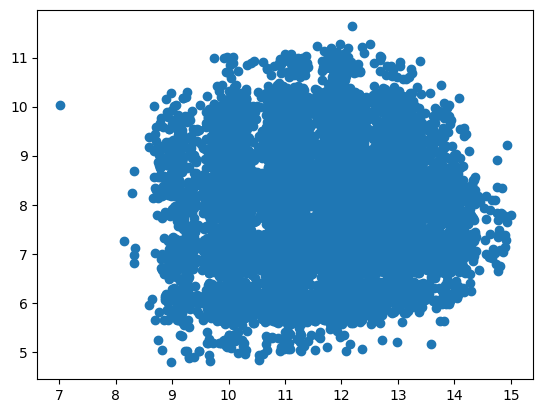

In [5]:
x_y_pos = np.tanh(model.readout.position.mean[:].cpu().detach().numpy())
#np.save("x_y_pos.npy", x_y_pos)
plt.scatter((x_y_pos[:, 0]+1)*12, (x_y_pos[:, 1]+1)*8)
plt.show()

In [6]:
def position_sample(batch_size=1):

    units = 9941

    mu = Parameter(torch.zeros(units, 2))
    mu.scale = units
    mu.decay = False

    sigma = Parameter(torch.eye(2).repeat(units, 1, 1))
    sigma.scale = units
    sigma.decay = False


    x = mu.repeat(batch_size, 1, 1)
    x = x + torch.einsum("U C D , N U D -> N U C", sigma, torch.randn_like(x))

    return x

def process_core_output(core):
    #position = torch.load("test_pos.pt")
    #self.position.mean.expand(core.size(0), -1, -1)
    #print("here")
    out = torch.nn.functional.grid_sample(
        core,
        grid = torch.nn.functional.tanh(model.readout.position.mean.expand(core.size(0), -1, -1)).unsqueeze(dim=2),
        mode = "bilinear",
        padding_mode="border",
        align_corners=False
    )
    return out

#process_core_output(None)

In [7]:
############# COLLECT LAYERS #################

# Function to get layers by name and type
def get_layers_by_name_and_type(model, substrings, layer_types):
    layers = []
    for name, module in model.named_modules():
        if any(sub in name for sub in substrings):
            if isinstance(module, fnn.model.elements.Conv) and ("skips" not in name) and ("convs.1" not in name):
                layers.append((name, module))
    return layers

# Collect layers based on the LAYER_TYPE and block
if LAYER_TYPE == 'act':
    layer_types = (nn.ReLU,)
elif LAYER_TYPE == 'conv':
    layer_types = (nn.Conv2d,)
elif LAYER_TYPE == 'dense':
    layer_types = (nn.Linear,)
else:
    raise ValueError('Invalid LAYER_TYPE')

layer_types = 'Conv'

layers_to_use = get_layers_by_name_and_type(model, block, layer_types)

if 'hidden' in block:
    layers_to_use.append(("hidden", model.core.recurrent))
if 'interpolation' in block:
    layers_to_use.append(("interpolation", model.readout.position))
if 'readout' in block:
    layers_to_use.append(("readout", model.readout))
if 'perspective' in block:
    layers_to_use = [("perspective", model.perspective)]

Nlayers = len(layers_to_use)
print(f'Number of layers to use: {Nlayers}')


# Set up hooks to capture activations
activation_outputs = {}

BATCH_SIZE=1
counter = 0
def get_activation(name):
    print(name)

    if name == "hidden":
        def hook(model, input, output):
            
            if hasattr(module, 'past') and module.past is not None:
                if isinstance(module.past, dict):
                    
                    if not name in activation_outputs:
                        activation_outputs[name] = {}
                    global counter
                    activation_outputs["hidden"][counter] = module.past["h"].clone()
                    #print(activation_outputs["hidden"][counter].shape)
                    #activation_outputs["hidden"][counter] = activation_outputs["hidden"][counter].clone()[:, :, :, 4:-4]
                    #print("new")
                    #print(activation_outputs["hidden"][counter].shape)
                    global layers_to_use
                    if name == layers_to_use[-1][0]:
                        
                        counter += 1
                        counter = counter % 37
    else:
        def hook(model, input, output):
            act_fct = torch.nn.GELU()
            
            if not name in activation_outputs:
                activation_outputs[name] = {}
            global counter
            if name == "core.recurrent.out" and get_pos:
                activation_outputs[name][counter] = process_core_output(output.detach())
            else:
                activation_outputs[name][counter] = output.detach()

            if get_act:
                activation_outputs[name][counter] = act_fct(activation_outputs[name][counter]) * 1.7015043497085571
           
            global layers_to_use
            #print(f"{counter}, {name}")
            if name == layers_to_use[-1][0]:
                
                counter += 1
                counter = counter % 37

    return hook

for name, module in layers_to_use:
    if name == "hidden":
        
        model.core.recurrent.register_forward_hook(get_activation(name))

    else:
        module.register_forward_hook(get_activation(name))

frames = concatenate([
    full(shape=[2, 144, 256], dtype="uint8", fill_value=0),   # 1 second of black
    full(shape=[2, 144, 256], dtype="uint8", fill_value=128), # 1 second of gray
    full(shape=[2, 144, 256], dtype="uint8", fill_value=255), # 1 second of white
])

with torch.no_grad():
    response = model.predict(stimuli=frames)


# Collect output shapes and compute pads
MAX_SIDE = 32
all_layer_totfmaps = []
all_layer_spacedims = []
out_pads = []
for name, module in layers_to_use:
    output = activation_outputs[name][0]
    #print("here")
    print(output.shape)
    if "interpolation" in name or "recurrent" in name or 'readout' in name:
        pad = False
    else:
        pad = True

    if not pad:
        output = output[:, :40]
    batch_size, channels, height, width = output.shape
    print(batch_size, channels, height, width)
    totfmaps = channels

    
    if pad:
        out_pad = height // 4 #max(1, (height - MAX_SIDE) // 2) * 3
        print(out_pad)
        h = height - out_pad
        w = width - out_pad
    else:
        out_pad = 0
        h = height
        w = width
        output = 0

    spacedims = [h, w, totfmaps]
    all_layer_totfmaps.append(totfmaps)
    all_layer_spacedims.append(spacedims)
    out_pads.append(out_pad)

all_layer_nunits = [np.prod(lspcd) for lspcd in all_layer_spacedims]

for li, (name, module) in enumerate(layers_to_use):
    print(f'{name}: {all_layer_totfmaps[li]} feature maps')
    print('  spacedims', all_layer_spacedims[li])
    print('  Total units:', all_layer_nunits[li], flush=True)


Number of layers to use: 1
core.feedforward.blocks.2.convs.0
torch.Size([1, 512, 16, 24])
1 512 16 24
4
core.feedforward.blocks.2.convs.0: 512 feature maps
  spacedims [12, 20, 512]
  Total units: 122880


tot_stims 88
frames_per_stim 37
*INSTANCE 0 ...........
*INSTANCE 1 ...........
*INSTANCE 2 ...........


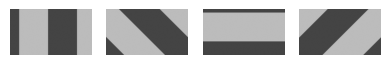

In [8]:

############# LOAD FLOW STIM FRAMES #################
counter = 0
orig_shape = (800, 600)

mydirs = list(map(str, range(0, 360, 45)))
categories = ['grat_W12', 'grat_W1', 'grat_W2',
              'neg1dotflow_D1_bg', 'neg3dotflow_D1_bg', 'neg1dotflow_D2_bg', 'neg3dotflow_D2_bg',
              'pos1dotflow_D1_bg', 'pos3dotflow_D1_bg', 'pos1dotflow_D2_bg', 'pos3dotflow_D2_bg']

topdir = 'flowstims'
NDIRS = len(mydirs)
tot_stims = len(categories) * NDIRS
print('tot_stims', tot_stims, flush=True)
frames_per_stim = (trial_len // stride)
print('frames_per_stim', frames_per_stim)

# Create flow datasets (placeholder function)
flow_datasets = createFlowDataset(categories, topdir, mydirs, orig_shape, input_shape,
                                  scl_factor, N_INSTANCES, trial_len, stride)

# Show example of sequence of frames generated for a stimulus trial
n_frames_to_show = 4
interval = 37

f, axes = subps(1, n_frames_to_show, 1, 1)
for i in range(n_frames_to_show):
    ax = axes[i]
    img = flow_datasets[0][i * interval].reshape(input_shape)
    ax.imshow(img, vmin=0, vmax=255, cmap='gray')
    ax.axis('off')

f.tight_layout()
plt.show()

In [9]:
print(flow_datasets[0].shape)
print(144*256)
print(3256 / 8 / 37)


(3256, 36864)
36864
11.0


In [10]:
"""def reshape_flow_img(raveled_1chan_img):
    img = raveled_1chan_img.reshape((37, input_shape[0], input_shape[1]))
    #img = np.stack([img, img, img], axis=0)  # Convert to 3 channels
    img = img.astype(np.uint8)
    return img




# Collect output shapes and compute pads
MAX_SIDE = 16
all_layer_totfmaps = []
all_layer_spacedims = []
out_pads = []
for name, module in layers_to_use:
    for seq_idx in range(int(len(flow_datasets[0])/37)):
        sequence = reshape_flow_img(flow_datasets[0][seq_idx*37:(seq_idx+1)*37])

        with torch.no_grad():
            response = model.predict(stimuli=sequence)
        for i in range(37):
            output = activation_outputs[name][i]
            plt.imshow(output.cpu()[0, 0], cmap="Grays")
            plt.show()"""

'def reshape_flow_img(raveled_1chan_img):\n    img = raveled_1chan_img.reshape((37, input_shape[0], input_shape[1]))\n    #img = np.stack([img, img, img], axis=0)  # Convert to 3 channels\n    img = img.astype(np.uint8)\n    return img\n\n\n\n\n# Collect output shapes and compute pads\nMAX_SIDE = 16\nall_layer_totfmaps = []\nall_layer_spacedims = []\nout_pads = []\nfor name, module in layers_to_use:\n    for seq_idx in range(int(len(flow_datasets[0])/37)):\n        sequence = reshape_flow_img(flow_datasets[0][seq_idx*37:(seq_idx+1)*37])\n\n        with torch.no_grad():\n            response = model.predict(stimuli=sequence)\n        for i in range(37):\n            output = activation_outputs[name][i]\n            plt.imshow(output.cpu()[0, 0], cmap="Grays")\n            plt.show()'

In [11]:

####################### COMPUTE ################

def reshape_flow_img(raveled_1chan_img):
    img = raveled_1chan_img.reshape((37, input_shape[0], input_shape[1]))
    #img = np.stack([img, img, img], axis=0)  # Convert to 3 channels
    img = img.astype(np.uint8)
    return img


TOL = 0

n_orig_imgs = tot_stims
n_shifts = frames_per_stim
n_shifted_imgs = n_orig_imgs * n_shifts


print('tot # of images:', n_orig_imgs, '*', n_shifts, '=', n_shifted_imgs)


layer_outputs = []
instance_layer_outputs = []

for li in range(len(layers_to_use)):
    shape = [n_shifted_imgs] + all_layer_spacedims[li]
    layer_outputs.append(np.zeros(shape, dtype='float32'))
    shape_inst = np.append([N_INSTANCES], shape)
    instance_layer_outputs.append(np.zeros(shape_inst, dtype='float32'))

for insti in range(N_INSTANCES):
    extX = flow_datasets[insti]
    assert extX.shape[0] == n_shifted_imgs

    print('INSTANCE', insti)
    start0 = time()
    layer_output = []
    for li in range(len(layers_to_use)):
        layer_output.append([])

    for seq_idx in range(int(len(extX)/37)):
        start = time()
        #print(bb, end=' ', flush=True)

        # Prepare batch
        sequence = extX[seq_idx*37:(seq_idx+1)*37]
        sequence = reshape_flow_img(extX[seq_idx*37:(seq_idx+1)*37])


        # Collect outputs per layer
        activation_outputs.clear()
        with torch.no_grad():

            _ = model.predict(stimuli=sequence)

        # Collect outputs per layer
        for li, (name, module) in enumerate(layers_to_use):
            for t in range(trial_len):
                output = activation_outputs[name][t].detach().cpu().numpy()
                if not pad:
                    output = output[:, :40]
                #print(output.shape)
                #print(all_layer_spacedims[li])
                # Crop the output if needed
                h, w, c = all_layer_spacedims[li]
                out_pad = out_pads[li]
                #print(out_pad)
                if output.ndim == 4:
                    # output shape: (batch_size, channels, height, width)
                    output_cropped = output[:, :, out_pad: out_pad + h, out_pad: out_pad + w]
                    # Rearrange to (batch_size, height, width, channels)
                    output_cropped = np.transpose(output_cropped, (0, 2, 3, 1))
                else:
                    output_cropped = output  # For dense layers

                #print(output_cropped.shape)

                layer_output[li].append(output_cropped)

        print('(%.1fs) ' % (time() - start), end='', flush=True)
    print(' Tot time = %.1f' % (time() - start0), flush=True)

    # After processing all batches for this instance, concatenate outputs
    for li in range(len(layers_to_use)):
        #print(li)
        #print([l.shape for l in layer_output[li]])
        layer_output[li] = np.concatenate(layer_output[li], axis=0)
        layer_outputs[li] += layer_output[li]
        instance_layer_outputs[li][insti] = layer_output[li]


# Average over instances
for li in range(len(layers_to_use)):
    layer_outputs[li] /= N_INSTANCES

tot # of images: 88 * 37 = 3256
INSTANCE 0
(0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.4s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s)  Tot time = 26.1
INSTANCE 1
(0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s) (0.3s

In [12]:

if layers_to_use[-1][0] == "hidden" and save_hidden:
    np.save("../data/hidden_states.npy", layer_outputs[0])

In [13]:
################### SUMMARIZE ACTIVITY ###########

print('Activities per img:', end=' ')
all_neurons_maxs = []
all_neurons_means = []
all_per_img_output = []
for li in range(len(layers_to_use)):
    print(li, end='', flush=True)
    layer_output_ = layer_outputs[li].copy()


    layer_output_[layer_output_ < 0] = 0

    nfmaps = layer_output_.shape[3]
    # Reshape to [n_orig_imgs, n_shifts, nfmaps, -1]
    orig_per_img_output = np.moveaxis(layer_output_, -1, 1).reshape([n_orig_imgs, n_shifts, nfmaps, -1])
    orig_per_img_output = np.moveaxis(orig_per_img_output, 1, -1)



    # Normalize each image by the max
    layer_output_ /= np.maximum(layer_output_.max((1, 2, 3), keepdims=True), 1e-8)

    per_img_output = np.moveaxis(layer_output_, -1, 1).reshape([n_orig_imgs, n_shifts, nfmaps, -1])
    per_img_output = np.moveaxis(per_img_output, 1, -1)

    tot_n_neurons = np.prod(layer_output_.shape[1:])

    neurons_maxs = np.zeros(per_img_output.shape[1:3])
    neurons_means = np.zeros(per_img_output.shape[1:3])

    for imi in range(n_orig_imgs):

        if samp_max_one_dir and imi % NDIRS > 0:
            im_avgs = 0
        else:
            im_avgs = per_img_output[imi].mean(2)  # Averaging across time
        neurons_maxs = np.maximum(neurons_maxs, im_avgs)
        neurons_means += im_avgs
        
    neurons_means /= n_orig_imgs

    idxs = neurons_maxs.mean(1).argsort()

    if li == 0:
        all_neurons_maxs = neurons_maxs
        all_neurons_means = neurons_means
        all_per_img_output = orig_per_img_output
    else:
        all_neurons_maxs = np.concatenate([all_neurons_maxs, neurons_maxs], 0)
        all_neurons_means = np.concatenate([all_neurons_means, neurons_means], 0)
        all_per_img_output = np.concatenate([all_per_img_output, orig_per_img_output], 1)

Activities per img: 0

In [14]:
############# SAMPLE NEURONS ###########

nfmaps, n_neurons_per_fmap = all_neurons_maxs.shape
layer_is_per_fmap = np.concatenate([li * np.ones(nf) for li, nf in enumerate(all_layer_totfmaps)])
np.random.seed(seed)

maxsmean = all_neurons_maxs.mean(1)
nonzero_indices = (~np.isclose(maxsmean, 0)).sum()
n_fmaps_to_sample_ = min(n_fmaps_to_sample, nonzero_indices)
print(n_fmaps_to_sample)
if fmap_samp_method == 'maxFr':
    probabilities = maxsmean / maxsmean.sum()
    top_fmaps = np.random.choice(range(nfmaps), n_fmaps_to_sample_, replace=False, p=probabilities)
elif fmap_samp_method == "random":
    top_fmaps = np.random.choice(range(nfmaps), n_fmaps_to_sample_, replace=False) 
else:
    raise ValueError('Invalid fmap_samp_method')

# Pick active neurons in each of these feature maps
sampled_neurons = []

samples_per_fmap = min(samples_per_fmap, all_neurons_means.shape[1])
print(samples_per_fmap)
for fi in top_fmaps:
    if neur_samp_method == 'maxNr':
        neuron_vals = all_neurons_maxs[fi]
        nonzero_neurons = (~np.isclose(neuron_vals, 0)).sum()
        samples_per_fmap_ = min(samples_per_fmap, nonzero_neurons)
        probabilities = neuron_vals / neuron_vals.sum()
        top_nis = np.random.choice(range(n_neurons_per_fmap), samples_per_fmap_, replace=False, p=probabilities)
    else:
        raise ValueError('Invalid neur_samp_method')
    sampled_neurons += list(fi * n_neurons_per_fmap + top_nis)
sampled_neurons = np.array(sampled_neurons)
n_neurons_to_pick = len(sampled_neurons)
print(n_neurons_to_pick)

40
50
2000


In [15]:

######### BUILD TENSOR ##########

def get_neuron_pos(ni):
    """From sampled indices ni, get original indices back (layer index, fmap, posi, posj, raveled_idx)"""
    fi = ni // n_neurons_per_fmap
    li = int(layer_is_per_fmap[fi])
    ij = ni % n_neurons_per_fmap
    h, w, _ = all_layer_spacedims[li]
    ii = ij // w
    jj = ij % w
    return li, fi, ii, jj, ij

assert n_orig_imgs // NDIRS == len(categories)

tensorX = np.zeros((n_neurons_to_pick, len(categories), NDIRS, n_shifts))
neurons_used = np.empty((n_neurons_to_pick, 5), dtype='int')

# Collect PSTs for those sampled neurons
for nii, ni in enumerate(sampled_neurons):
    li, fi, ii, jj, posi = get_neuron_pos(ni)
    neurons_used[nii] = [li, fi, ii, jj, posi]

    for cati in range(len(categories)):
        pst = all_per_img_output[cati * NDIRS: (cati + 1) * NDIRS, fi, posi, :]
        tensorX[nii, cati] = pst






In [16]:
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu, ks_2samp

def compare_weight_distributions(selected_weights, other_weights):
    """
    Compare two weight distributions to test if selected_weights are smaller than other_weights.
    
    Parameters:
    -----------
    selected_weights : array-like
        First group of weights (hypothesized to be smaller)
    other_weights : array-like
        Second group of weights (hypothesized to be larger)
    
    Returns:
    --------
    dict : Dictionary containing test results and statistics
    """
    
    # Convert to numpy arrays and flatten
    selected_weights = np.array(selected_weights).flatten()
    other_weights = np.array(other_weights).flatten()
    
    # Remove any NaN values
    selected_weights = selected_weights[~np.isnan(selected_weights)]
    other_weights = other_weights[~np.isnan(other_weights)]
    
    print("=" * 60)
    print("WEIGHT DISTRIBUTION COMPARISON ANALYSIS")
    print("=" * 60)
    
    # Basic descriptive statistics
    print("\n1. DESCRIPTIVE STATISTICS")
    print("-" * 40)
    print(f"Selected weights (n={len(selected_weights)}):")
    print(f"  Mean: {np.mean(selected_weights):.4f}")
    print(f"  Median: {np.median(selected_weights):.4f}")
    print(f"  Std: {np.std(selected_weights):.4f}")
    print(f"  Min: {np.min(selected_weights):.4f}")
    print(f"  Max: {np.max(selected_weights):.4f}")
    print(f"  25th percentile: {np.percentile(selected_weights, 25):.4f}")
    print(f"  75th percentile: {np.percentile(selected_weights, 75):.4f}")
    
    print(f"\nOther weights (n={len(other_weights)}):")
    print(f"  Mean: {np.mean(other_weights):.4f}")
    print(f"  Median: {np.median(other_weights):.4f}")
    print(f"  Std: {np.std(other_weights):.4f}")
    print(f"  Min: {np.min(other_weights):.4f}")
    print(f"  Max: {np.max(other_weights):.4f}")
    print(f"  25th percentile: {np.percentile(other_weights, 25):.4f}")
    print(f"  75th percentile: {np.percentile(other_weights, 75):.4f}")
    
    # Difference in means and medians
    mean_diff = np.mean(selected_weights) - np.mean(other_weights)
    median_diff = np.median(selected_weights) - np.median(other_weights)
    
    print(f"\nDifference (Selected - Other):")
    print(f"  Mean difference: {mean_diff:.4f}")
    print(f"  Median difference: {median_diff:.4f}")
    
    # Test for normality
    print("\n2. NORMALITY TESTS")
    print("-" * 40)
    
    # Shapiro-Wilk test (good for smaller samples)
    if len(selected_weights) <= 5000:
        shapiro_selected = stats.shapiro(selected_weights)
        print(f"Selected weights - Shapiro-Wilk: p-value = {shapiro_selected.pvalue:.4f}")
        print(f"  {'Normal' if shapiro_selected.pvalue > 0.05 else 'Non-normal'} distribution")
    
    if len(other_weights) <= 5000:
        shapiro_other = stats.shapiro(other_weights)
        print(f"Other weights - Shapiro-Wilk: p-value = {shapiro_other.pvalue:.4f}")
        print(f"  {'Normal' if shapiro_other.pvalue > 0.05 else 'Non-normal'} distribution")
    
    # Kolmogorov-Smirnov test for normality (better for larger samples)
    ks_selected = stats.kstest(selected_weights, 'norm', args=(np.mean(selected_weights), np.std(selected_weights)))
    ks_other = stats.kstest(other_weights, 'norm', args=(np.mean(other_weights), np.std(other_weights)))
    
    print(f"\nKolmogorov-Smirnov test against normal distribution:")
    print(f"Selected weights: p-value = {ks_selected.pvalue:.4f}")
    print(f"Other weights: p-value = {ks_other.pvalue:.4f}")
    
    # Hypothesis testing
    print("\n3. HYPOTHESIS TESTING")
    print("-" * 40)
    print("H0: Selected weights >= Other weights")
    print("H1: Selected weights < Other weights (one-tailed test)")
    
    # Mann-Whitney U test (non-parametric, good for non-normal data)
    mw_statistic, mw_pvalue = mannwhitneyu(selected_weights, other_weights, alternative='less')
    print(f"\nMann-Whitney U test (non-parametric):")
    print(f"  Statistic: {mw_statistic:.4f}")
    print(f"  p-value: {mw_pvalue:.4f}")
    print(f"  Result: {'Reject H0' if mw_pvalue < 0.05 else 'Fail to reject H0'}")
    print(f"  Conclusion: {'Selected weights are significantly smaller' if mw_pvalue < 0.05 else 'No significant difference'}")
    
    # Welch's t-test (handles unequal variances)
    t_statistic, t_pvalue = stats.ttest_ind(selected_weights, other_weights, equal_var=False)
    t_pvalue_one_tailed = t_pvalue / 2 if t_statistic < 0 else 1 - t_pvalue / 2
    
    print(f"\nWelch's t-test (parametric, unequal variances):")
    print(f"  t-statistic: {t_statistic:.4f}")
    print(f"  p-value (one-tailed): {t_pvalue_one_tailed:.4f}")
    print(f"  Result: {'Reject H0' if t_pvalue_one_tailed < 0.05 else 'Fail to reject H0'}")
    
    # Kolmogorov-Smirnov two-sample test
    ks2_statistic, ks2_pvalue = ks_2samp(selected_weights, other_weights)
    print(f"\nKolmogorov-Smirnov two-sample test:")
    print(f"  Statistic: {ks2_statistic:.4f}")
    print(f"  p-value: {ks2_pvalue:.4f}")
    print(f"  Result: {'Distributions are significantly different' if ks2_pvalue < 0.05 else 'No significant difference'}")
    
    # Effect size (Cohen's d)
    pooled_std = np.sqrt(((len(selected_weights) - 1) * np.var(selected_weights) + 
                         (len(other_weights) - 1) * np.var(other_weights)) / 
                        (len(selected_weights) + len(other_weights) - 2))
    cohens_d = (np.mean(selected_weights) - np.mean(other_weights)) / pooled_std
    
    print(f"\nEffect size (Cohen's d): {cohens_d:.4f}")
    if abs(cohens_d) < 0.2:
        effect_size_desc = "negligible"
    elif abs(cohens_d) < 0.5:
        effect_size_desc = "small"
    elif abs(cohens_d) < 0.8:
        effect_size_desc = "medium"
    else:
        effect_size_desc = "large"
    print(f"Effect size interpretation: {effect_size_desc}")
    
    # Plotting
    print("\n4. GENERATING PLOTS")
    print("-" * 40)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Histograms
    axes[0, 0].hist(selected_weights, bins=30, alpha=0.7, label='Potentially Inhibitory', color='skyblue', density=True)
    axes[0, 0].hist(other_weights, bins=30, alpha=0.7, label='Other', color='lightcoral', density=True)
    axes[0, 0].set_xlabel('Weight values')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].set_title('Weight Value Histogram')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Box plots
    data_to_plot = [selected_weights, other_weights]
    box_plot = axes[0, 1].boxplot(data_to_plot, labels=['Inhibitory', 'Other'], patch_artist=True)
    box_plot['boxes'][0].set_facecolor('skyblue')
    box_plot['boxes'][1].set_facecolor('lightcoral')
    axes[0, 1].set_ylabel('Weight values')
    axes[0, 1].set_title('Box Plot Comparison')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Violin plots
    axes[1, 0].violinplot([selected_weights, other_weights], positions=[1, 2], showmeans=True, showmedians=True)
    axes[1, 0].set_xticks([1, 2])
    axes[1, 0].set_xticklabels(['Selected', 'Other'])
    axes[1, 0].set_ylabel('Weight values')
    axes[1, 0].set_title('Violin Plot Comparison')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Q-Q plot
    from scipy.stats import probplot
    combined_data = np.concatenate([selected_weights, other_weights])
    probplot(selected_weights, dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title('Q-Q Plot: Selected Weights vs Normal Distribution')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary
    print("\n5. SUMMARY")
    print("-" * 40)
    print(f"Sample sizes: Selected={len(selected_weights)}, Other={len(other_weights)}")
    print(f"Mean difference: {mean_diff:.4f}")
    print(f"Mann-Whitney U p-value: {mw_pvalue:.4f}")
    print(f"Effect size (Cohen's d): {cohens_d:.4f}")
    
    if mw_pvalue < 0.05:
        print("✓ HYPOTHESIS SUPPORTED: Selected weights are significantly smaller than other weights")
    else:
        print("✗ HYPOTHESIS NOT SUPPORTED: No significant difference found")
    
    # Return results dictionary
    results = {
        'selected_stats': {
            'mean': np.mean(selected_weights),
            'median': np.median(selected_weights),
            'std': np.std(selected_weights),
            'n': len(selected_weights)
        },
        'other_stats': {
            'mean': np.mean(other_weights),
            'median': np.median(other_weights),
            'std': np.std(other_weights),
            'n': len(other_weights)
        },
        'tests': {
            'mann_whitney_u': {'statistic': mw_statistic, 'pvalue': mw_pvalue},
            'welch_t_test': {'statistic': t_statistic, 'pvalue': t_pvalue_one_tailed},
            'ks_2sample': {'statistic': ks2_statistic, 'pvalue': ks2_pvalue},
            'cohens_d': cohens_d
        },
        'hypothesis_supported': mw_pvalue < 0.05
    }
    
    return results


######### EXTRACT OUTGOING WEIGHTS ##########
save_outgoing_weights = False
if save_outgoing_weights:
    print("Extracting outgoing weights for sampled neurons...")
    
    # Find the source layer (blocks.2.convs.0) that we're sampling from
    source_layer_name = None
    source_layer_module = None
    
    # Find the target layer (blocks.2.convs.1) to extract outgoing weights from
    target_layer_name = None
    target_layer_module = None
    
    for name, module in model.named_modules():
        if 'blocks.2.convs.0' in name and isinstance(module, fnn.model.elements.Conv):
            source_layer_name = name
            source_layer_module = module
            print(module)
            print(f"Found source layer (sampling from): {source_layer_name}")
        elif 'blocks.2.convs.1' in name and isinstance(module, fnn.model.elements.Conv):
            target_layer_name = name
            target_layer_module = module
            print(f"Found target layer (outgoing weights): {target_layer_name}")
    
    if target_layer_module is None:
        print("Warning: Could not find blocks.2.convs.1 layer for outgoing weight extraction")
        outgoing_weights = None
    else:
        # Get the weight tensor from the target conv layer (blocks.2.convs.1)
        # Shape: (out_channels, in_channels, kernel_height, kernel_width)
        print(target_layer_module.weights[0].shape)
        layer_weights = np.reshape(np.stack((
            target_layer_module.weights[0].detach().cpu().numpy(),
            target_layer_module.weights[1].detach().cpu().numpy(),
            target_layer_module.weights[2].detach().cpu().numpy(),
            target_layer_module.weights[3].detach().cpu().numpy()
        )), (512, 32, 3, 3, 3))
        print(f"Target layer weights shape: {layer_weights.shape}")

        idx = [212,101, 114, 754, 121, 100, 466, 120, 108, 1313, 934, 588, 144, 776, 129,502,122,229,753,102,788,16,1321,785,787,523,44,390,116,213,1162,543,592,214,579,550,1986,342,935,235,234,143,217,562,760,752,46,775,185,204,236,598,583,964,951,219,501,200,1950,1241,148,927,792,1594,967,497,1649,463,493,793,1619,380,241,1623,821,1060,829,1623,1959,714,858,1632,766,1238,1179,392,1621,780,228,345,1982,194]
        #idx = list(range(1000, 2000))
        inhibitory_weigths = []
        inhibitory_fmaps = []
        other_weights = []
        done = []
        for nii, ni in enumerate(sampled_neurons):
            li, fi, ii, jj, posi = get_neuron_pos(ni)
            if nii in idx and fi not in inhibitory_fmaps:
                inhibitory_fmaps.append(fi)
            #print(f"li={li}")
        for nii, ni in enumerate(sampled_neurons):
            li, fi, ii, jj, posi = get_neuron_pos(ni)
            if fi not in done:
                if fi in inhibitory_fmaps:
                    inhibitory_weigths.append(layer_weights[fi])
                else:
                    other_weights.append(layer_weights[fi])
                done.append(fi)
        print(len(inhibitory_weigths))
        print(len(other_weights))

        compare_weight_distributions(inhibitory_weigths, other_weights)



In [17]:
if get_pos:
    block[block == 'recurrent.out'] = 'position'
for i in range(len(block)):
    block[i] = block[i].replace('.', '')
SUFFIX = f"{model_name}_{LAYER_TYPE}_i{N_INSTANCES}_n{n_neurons_to_pick}_SCL{str(scl_factor).replace('.', '_')}_TL{trial_len}_{'_'.join(block)}_{fmap_samp_method}_{neur_samp_method}"
if samp_max_one_dir:
    SUFFIX += '_onedir'
if seed > 0:
    SUFFIX += f'_seed{seed}'

print(SUFFIX)

directory = '../data/sampled_data'
os.makedirs(directory, exist_ok=True)

if os.path.exists(f'../data/sampled_data/tensor4d_{SUFFIX}.npy'):
    print("Files already exist, please delete them to prevent conflicts.")
else:
    
    np.save(f'../data/sampled_data/tensor4d_{SUFFIX}.npy', tensorX)
    print(f'tensor4d_{SUFFIX}.npy Saved.')

    np.save(f'../data/sampled_data/neurons_used_{SUFFIX}.npy', neurons_used)
    print(f'neurons_used_{SUFFIX}.npy Saved.')

fnn07_act_i3_n2000_SCL0_7_TL37_blocks2_maxFr_maxNr_seed3
tensor4d_fnn07_act_i3_n2000_SCL0_7_TL37_blocks2_maxFr_maxNr_seed3.npy Saved.
neurons_used_fnn07_act_i3_n2000_SCL0_7_TL37_blocks2_maxFr_maxNr_seed3.npy Saved.
